# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

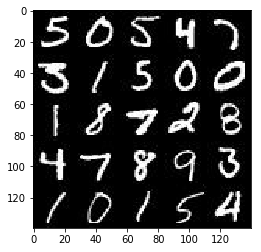

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

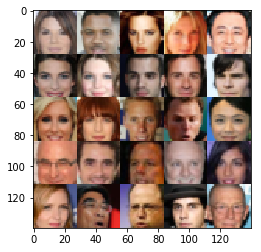

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.9.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_image = tf.placeholder(shape=[None, image_width, image_height, image_channels], dtype=tf.float32)
    noise_z = tf.placeholder(shape=[None, z_dim], dtype=tf.float32)
    learning_rate = tf.placeholder(dtype=tf.float32)

    return real_image, noise_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, is_training=False, alpha = 0.02):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
     
    drop_rate = 0.3
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # initially 28x28x3 or 28x28x1
        
        x1 = tf.layers.conv2d(images, 64, 5, (2,2), padding='same', activation=None)
        x1 = tf.layers.dropout(x1, drop_rate)
        x1 = tf.maximum(alpha*x1, x1)
        #now 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 3, (2,2), padding='same', activation=None, use_bias=False)
        x2 = tf.layers.batch_normalization(x2, axis=3, training=is_training)
        x2 = tf.layers.dropout(x2, drop_rate)
        x2 = tf.maximum(alpha*x2, x2)
        #now 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 3, (2,2), padding='same', activation=None, use_bias=False)
        x3 = tf.layers.batch_normalization(x3, axis=3, training=is_training)
        x3 = tf.layers.dropout(x3, drop_rate)
        x3 = tf.maximum(alpha*x3, x3)
        #now 4x4x256
        
        x4 = tf.layers.conv2d(x3, 512, 3, (2,2), padding='same', activation=None, use_bias=False)
        x4 = tf.layers.batch_normalization(x4, axis=3, training=is_training)
        x4 = tf.layers.dropout(x4, drop_rate)
        x4 = tf.maximum(alpha*x4, x4)
        #now 2x2x512
        
        x5 = tf.layers.flatten(x4)
        
        logits = tf.layers.dense(x5, 1)
        op = tf.sigmoid(logits)
        
    return (op, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # reuse all the generator network during the image generation (No training mode) and 
    #while training there will be no need to reuse as we are training it first
    
    drop_rate = 0.5
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        # initially e.g. 100 dim col vector
        """
        g0 = tf.layers.dense(z, 512)
        g0 = tf.maximum(alpha*g0, g0)

        g1 = tf.layers.dense(g0, 3*3*512, use_bias=False)
        """
        g1 = tf.layers.dense(z, 3*3*512, use_bias=False)
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.layers.dropout(g1, drop_rate)
        g1 = tf.maximum(alpha*g1, g1)
        
        #print("g1", g1.get_shape().as_list())
        g1 = tf.reshape(g1, shape=[-1, 3, 3, 512])
        #print("g1-rs", g1.get_shape().as_list())
        # now 3x3x512

        g2 = tf.layers.conv2d_transpose(g1, 256, kernel_size=3, strides=(2,2), padding='valid', activation=None, use_bias=False)
        g2 = tf.layers.batch_normalization(g2, axis=3, training=is_train)
        g2 = tf.layers.dropout(g2, drop_rate)
        g2 = tf.maximum(alpha*g2, alpha)
        #print("g2", g2.get_shape().as_list())
        # now 7x7x256

        g3 = tf.layers.conv2d_transpose(g2, 128, kernel_size=3, strides=(2,2), padding='same', activation=None, use_bias=False)
        g3 = tf.layers.batch_normalization(g3, axis=3, training=is_train)
        g3 = tf.layers.dropout(g3, drop_rate)
        g3 = tf.maximum(alpha*g3, alpha)
        #print("g3", g3.get_shape().as_list())
        # now 14x14x128

        g4 = tf.layers.conv2d_transpose(g3, out_channel_dim, kernel_size=3, strides=(2,2), padding='same', activation=tf.nn.tanh, use_bias=True)
        #print("g4", g4.get_shape().as_list())
        # now 28x28x3

        return g4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, is_training=True):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    real_coefficient = tf.random_uniform(shape=[1], minval=0.7, maxval=0.95, dtype=tf.float32)
    fake_coefficient = tf.random_uniform(shape=[1], minval=0.05, maxval=0.3, dtype=tf.float32)    
    
    g1 = generator(input_z, out_channel_dim, is_train=is_training, alpha=0.01)
        
    d_out_real, d_logits_real = discriminator(input_real, is_training=is_training, alpha=0.01)
    d_out_fake, d_logits_fake = discriminator(g1, is_training=is_training, alpha=0.01, reuse=True)
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_out_fake)*fake_coefficient, logits=d_logits_fake))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_out_real)*real_coefficient, logits=d_logits_real))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_out_fake)*real_coefficient, logits=d_logits_fake))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):    
        d_train = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_train, g_train)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [46]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    real_image_input, noise_of_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(real_image_input, noise_of_z, data_shape[3], is_training=True)
    
    d_train, g_train = model_opt(d_loss, g_loss, learn_rate, beta1)
      
    noise_z_sample = tf.placeholder(shape=[None, z_dim], dtype=tf.float32)
    Z_val_sample = np.random.normal(0, 1, size=(batch_size, z_dim))
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            i = 1
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                Z_val = np.random.normal(0, 1, size=(batch_size, z_dim))
                batch_images = batch_images*2
                d_run = sess.run(d_train, feed_dict={real_image_input: batch_images, noise_of_z: Z_val, learn_rate: learning_rate})
                g_run = sess.run(g_train, feed_dict={real_image_input: batch_images, noise_of_z: Z_val, learn_rate: learning_rate})
                
                if i % 100 == 0:
                    disc_loss = sess.run(d_loss, feed_dict={real_image_input: batch_images, noise_of_z: Z_val})
                    gen_loss = sess.run(g_loss, feed_dict={noise_of_z: Z_val})
                    print("Batch No.: {}".format(i),
                          "Discriminator Loss: {}".format(disc_loss),
                          "Generative Loss: {}".format(gen_loss))
                                
                if i % 500 == 0:
                    sess.run(noise_z_sample, feed_dict={noise_z_sample:Z_val_sample})
                    show_generator_output(sess, 20, noise_z_sample, data_shape[3], data_image_mode)
                i += 1
                
            #disc_loss = sess.run(d_loss, feed_dict={real_image_input: batch_images, noise_of_z: Z_val})
            #gen_loss = sess.run(g_loss, feed_dict={noise_of_z: Z_val})
                   
            print("Epoch {}/{}".format(epoch_i+1, epoch_count),
                    "Discriminator Loss: {}".format(disc_loss),
                    "Generative Loss: {}".format(gen_loss))
            show_generator_output(sess, 20, noise_of_z, data_shape[3], data_image_mode)
            saver = tf.train.Saver()
            save_path = saver.save(sess, "/tmp/model.ckpt")
            print("Model saved in path: %s" % save_path)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Batch No.: 100 Discriminator Loss: 0.48159611225128174 Generative Loss: 5.461924076080322
Batch No.: 200 Discriminator Loss: 0.6038501262664795 Generative Loss: 6.305389404296875
Batch No.: 300 Discriminator Loss: 0.6437801122665405 Generative Loss: 6.539641857147217
Batch No.: 400 Discriminator Loss: 0.5425567626953125 Generative Loss: 6.065023422241211
Batch No.: 500 Discriminator Loss: 0.6472464203834534 Generative Loss: 2.2160191535949707


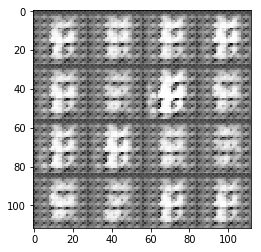

Batch No.: 600 Discriminator Loss: 0.49862831830978394 Generative Loss: 5.832355499267578
Batch No.: 700 Discriminator Loss: 0.49952104687690735 Generative Loss: 5.3239312171936035
Batch No.: 800 Discriminator Loss: 0.37408125400543213 Generative Loss: 6.305582523345947
Batch No.: 900 Discriminator Loss: 0.40708738565444946 Generative Loss: 6.278958797454834
Batch No.: 1000 Discriminator Loss: 0.3152100741863251 Generative Loss: 6.800004959106445


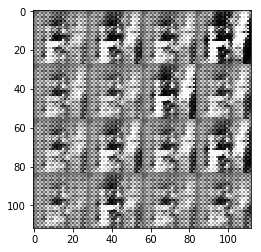

Batch No.: 1100 Discriminator Loss: 0.3576402962207794 Generative Loss: 6.038600444793701
Batch No.: 1200 Discriminator Loss: 0.7537133097648621 Generative Loss: 2.997738838195801
Batch No.: 1300 Discriminator Loss: 0.39301660656929016 Generative Loss: 3.100489854812622
Batch No.: 1400 Discriminator Loss: 0.6222976446151733 Generative Loss: 5.955132961273193
Batch No.: 1500 Discriminator Loss: 0.45201998949050903 Generative Loss: 4.307778835296631


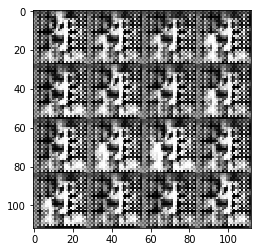

Batch No.: 1600 Discriminator Loss: 0.5442243814468384 Generative Loss: 2.53409481048584
Batch No.: 1700 Discriminator Loss: 0.402086079120636 Generative Loss: 6.536979675292969
Batch No.: 1800 Discriminator Loss: 0.7355796694755554 Generative Loss: 2.570993423461914
Batch No.: 1900 Discriminator Loss: 0.5394340753555298 Generative Loss: 6.100538730621338
Batch No.: 2000 Discriminator Loss: 0.7221162915229797 Generative Loss: 1.7250953912734985


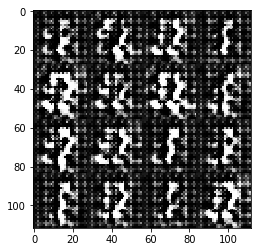

Batch No.: 2100 Discriminator Loss: 1.1240901947021484 Generative Loss: 1.147046685218811
Batch No.: 2200 Discriminator Loss: 0.7966862320899963 Generative Loss: 1.1123439073562622
Batch No.: 2300 Discriminator Loss: 0.6821209788322449 Generative Loss: 3.4739253520965576
Batch No.: 2400 Discriminator Loss: 0.507533073425293 Generative Loss: 2.4358692169189453
Batch No.: 2500 Discriminator Loss: 0.6568511128425598 Generative Loss: 2.0518248081207275


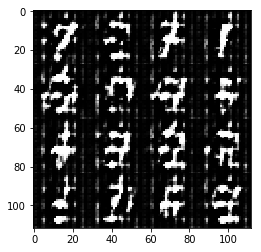

Epoch 1/2 Discriminator Loss: 0.6568511128425598 Generative Loss: 2.0518248081207275


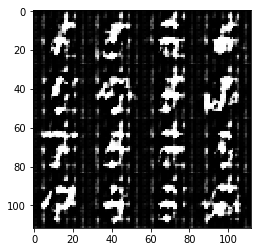

Model saved in path: /tmp/model.ckpt
Batch No.: 100 Discriminator Loss: 0.5375683903694153 Generative Loss: 1.7723251581192017
Batch No.: 200 Discriminator Loss: 1.6740639209747314 Generative Loss: 0.6321073174476624
Batch No.: 300 Discriminator Loss: 0.7266718745231628 Generative Loss: 0.965563952922821
Batch No.: 400 Discriminator Loss: 0.8242297768592834 Generative Loss: 4.399192810058594
Batch No.: 500 Discriminator Loss: 0.6511936187744141 Generative Loss: 2.0557594299316406


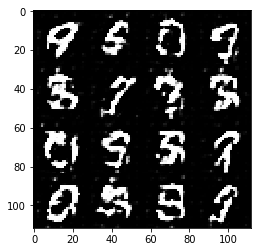

Batch No.: 600 Discriminator Loss: 0.5512070655822754 Generative Loss: 3.875119924545288
Batch No.: 700 Discriminator Loss: 0.5052040815353394 Generative Loss: 2.008054733276367
Batch No.: 800 Discriminator Loss: 0.8502289056777954 Generative Loss: 1.5470662117004395
Batch No.: 900 Discriminator Loss: 0.6020185947418213 Generative Loss: 1.435416340827942
Batch No.: 1000 Discriminator Loss: 0.6192952394485474 Generative Loss: 2.34377384185791


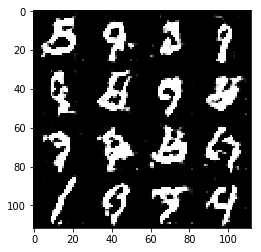

Batch No.: 1100 Discriminator Loss: 0.5645426511764526 Generative Loss: 1.9849729537963867
Batch No.: 1200 Discriminator Loss: 0.6897094249725342 Generative Loss: 1.6904010772705078
Batch No.: 1300 Discriminator Loss: 1.1760947704315186 Generative Loss: 2.8598759174346924
Batch No.: 1400 Discriminator Loss: 1.4399784803390503 Generative Loss: 0.4946630001068115
Batch No.: 1500 Discriminator Loss: 0.6976036429405212 Generative Loss: 1.5129493474960327


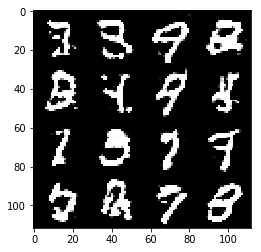

Batch No.: 1600 Discriminator Loss: 0.8181044459342957 Generative Loss: 1.9095550775527954
Batch No.: 1700 Discriminator Loss: 1.291823148727417 Generative Loss: 0.7748462557792664
Batch No.: 1800 Discriminator Loss: 0.8710601329803467 Generative Loss: 2.4460878372192383
Batch No.: 1900 Discriminator Loss: 0.7080023288726807 Generative Loss: 1.065116286277771
Batch No.: 2000 Discriminator Loss: 0.8611825108528137 Generative Loss: 1.0843955278396606


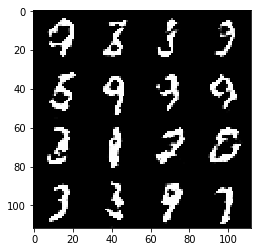

Batch No.: 2100 Discriminator Loss: 0.8277621269226074 Generative Loss: 2.674896478652954
Batch No.: 2200 Discriminator Loss: 0.564575731754303 Generative Loss: 1.3092284202575684
Batch No.: 2300 Discriminator Loss: 0.97381591796875 Generative Loss: 1.049364447593689
Batch No.: 2400 Discriminator Loss: 2.4821043014526367 Generative Loss: 0.617824137210846
Batch No.: 2500 Discriminator Loss: 0.5922565460205078 Generative Loss: 2.2440145015716553


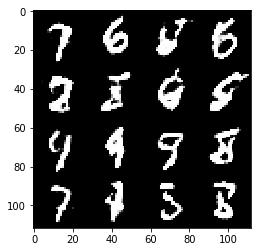

Epoch 2/2 Discriminator Loss: 0.5922565460205078 Generative Loss: 2.2440145015716553


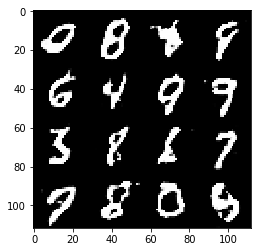

Model saved in path: /tmp/model.ckpt


In [22]:
#with dropout
# disc_drop = 0.3
# gen_drop = 0.5

batch_size = 24
z_dim = 100
learning_rate = 0.00095
beta1 = 0.29

#with 0.7-0.95 - disc_coeff
#with 0.05-0.3 - gen_coeff


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Batch No.: 100 Discriminator Loss: 0.26664018630981445 Generative Loss: 4.313727378845215
Batch No.: 200 Discriminator Loss: 0.5251060128211975 Generative Loss: 5.6894989013671875
Batch No.: 300 Discriminator Loss: 0.53725266456604 Generative Loss: 7.601396560668945
Batch No.: 400 Discriminator Loss: 0.46026623249053955 Generative Loss: 7.354814529418945
Batch No.: 500 Discriminator Loss: 0.5479763150215149 Generative Loss: 3.6787045001983643


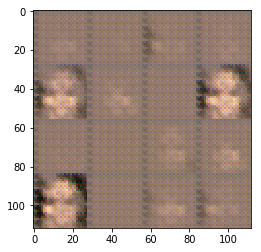

Batch No.: 600 Discriminator Loss: 0.4375206232070923 Generative Loss: 5.7948832511901855
Batch No.: 700 Discriminator Loss: 0.9413000345230103 Generative Loss: 1.1038967370986938
Batch No.: 800 Discriminator Loss: 0.23886695504188538 Generative Loss: 3.8560736179351807
Batch No.: 900 Discriminator Loss: 0.6542661190032959 Generative Loss: 4.682520389556885
Batch No.: 1000 Discriminator Loss: 0.5753514170646667 Generative Loss: 5.01638650894165


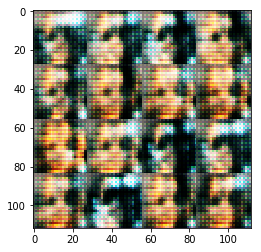

Batch No.: 1100 Discriminator Loss: 0.7836829423904419 Generative Loss: 2.0016534328460693
Batch No.: 1200 Discriminator Loss: 0.8335812091827393 Generative Loss: 1.2253704071044922
Batch No.: 1300 Discriminator Loss: 0.3804750442504883 Generative Loss: 3.486009120941162
Batch No.: 1400 Discriminator Loss: 0.5088333487510681 Generative Loss: 3.7013673782348633
Batch No.: 1500 Discriminator Loss: 0.4204452335834503 Generative Loss: 3.4654793739318848


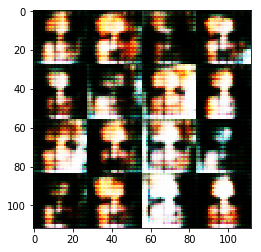

Batch No.: 1600 Discriminator Loss: 0.5565284490585327 Generative Loss: 3.492410898208618
Batch No.: 1700 Discriminator Loss: 0.3520960211753845 Generative Loss: 2.2076635360717773
Batch No.: 1800 Discriminator Loss: 0.5162197947502136 Generative Loss: 1.726866364479065
Batch No.: 1900 Discriminator Loss: 0.8702967166900635 Generative Loss: 0.9351992607116699
Batch No.: 2000 Discriminator Loss: 1.1884353160858154 Generative Loss: 0.7666284441947937


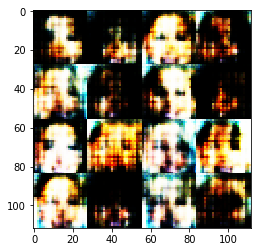

Batch No.: 2100 Discriminator Loss: 0.6941254734992981 Generative Loss: 2.83076810836792
Batch No.: 2200 Discriminator Loss: 1.0887608528137207 Generative Loss: 1.005924940109253
Batch No.: 2300 Discriminator Loss: 0.5572939515113831 Generative Loss: 1.6932222843170166
Batch No.: 2400 Discriminator Loss: 0.8681262731552124 Generative Loss: 0.8367244005203247
Batch No.: 2500 Discriminator Loss: 0.8734786510467529 Generative Loss: 1.9209288358688354


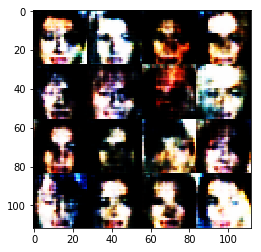

Batch No.: 2600 Discriminator Loss: 1.0370219945907593 Generative Loss: 1.113783836364746
Batch No.: 2700 Discriminator Loss: 0.7503585815429688 Generative Loss: 2.1040966510772705
Batch No.: 2800 Discriminator Loss: 0.91019606590271 Generative Loss: 1.2218801975250244
Batch No.: 2900 Discriminator Loss: 1.7465760707855225 Generative Loss: 0.5313026905059814
Batch No.: 3000 Discriminator Loss: 1.9393421411514282 Generative Loss: 0.3376215696334839


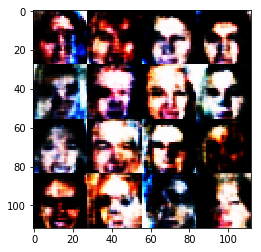

Batch No.: 3100 Discriminator Loss: 2.618481397628784 Generative Loss: 0.5109260082244873
Batch No.: 3200 Discriminator Loss: 1.0429625511169434 Generative Loss: 1.2433159351348877
Batch No.: 3300 Discriminator Loss: 0.6607796549797058 Generative Loss: 2.304767608642578
Batch No.: 3400 Discriminator Loss: 1.097148060798645 Generative Loss: 0.8482098579406738
Batch No.: 3500 Discriminator Loss: 1.755581259727478 Generative Loss: 0.5884954929351807


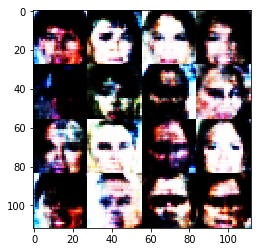

Batch No.: 3600 Discriminator Loss: 2.286015272140503 Generative Loss: 0.4905276298522949
Batch No.: 3700 Discriminator Loss: 0.8960937857627869 Generative Loss: 1.018121600151062
Batch No.: 3800 Discriminator Loss: 1.5235881805419922 Generative Loss: 0.6776281595230103
Batch No.: 3900 Discriminator Loss: 1.691001057624817 Generative Loss: 0.5652627348899841
Batch No.: 4000 Discriminator Loss: 1.2013280391693115 Generative Loss: 0.6788310408592224


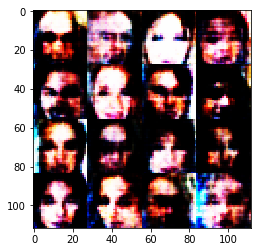

Batch No.: 4100 Discriminator Loss: 0.7536258697509766 Generative Loss: 1.7364096641540527
Batch No.: 4200 Discriminator Loss: 0.7808665633201599 Generative Loss: 1.9026732444763184
Batch No.: 4300 Discriminator Loss: 0.8252359628677368 Generative Loss: 1.629655361175537
Batch No.: 4400 Discriminator Loss: 0.6568100452423096 Generative Loss: 1.2164541482925415
Batch No.: 4500 Discriminator Loss: 1.3977597951889038 Generative Loss: 0.6733479499816895


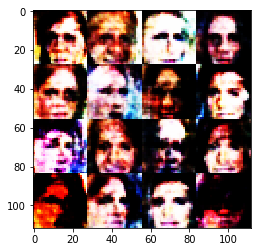

Batch No.: 4600 Discriminator Loss: 1.0782930850982666 Generative Loss: 0.8015313744544983
Batch No.: 4700 Discriminator Loss: 1.1530919075012207 Generative Loss: 0.6971392035484314
Batch No.: 4800 Discriminator Loss: 2.7043533325195312 Generative Loss: 0.6632089614868164
Batch No.: 4900 Discriminator Loss: 1.7172458171844482 Generative Loss: 0.6530666351318359
Batch No.: 5000 Discriminator Loss: 1.0133123397827148 Generative Loss: 0.8700606226921082


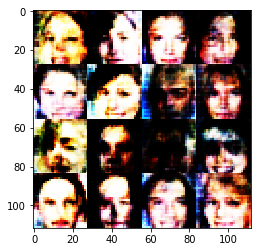

Batch No.: 5100 Discriminator Loss: 0.8928245306015015 Generative Loss: 0.9544752836227417
Batch No.: 5200 Discriminator Loss: 1.2300481796264648 Generative Loss: 0.8047161102294922
Batch No.: 5300 Discriminator Loss: 0.8835743069648743 Generative Loss: 1.0979208946228027
Batch No.: 5400 Discriminator Loss: 1.0367305278778076 Generative Loss: 2.3731651306152344
Batch No.: 5500 Discriminator Loss: 1.06663978099823 Generative Loss: 0.822526752948761


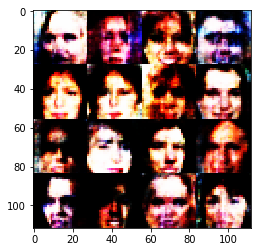

Batch No.: 5600 Discriminator Loss: 1.0399417877197266 Generative Loss: 1.0383542776107788
Batch No.: 5700 Discriminator Loss: 0.5115540623664856 Generative Loss: 2.5249295234680176
Batch No.: 5800 Discriminator Loss: 0.8776673078536987 Generative Loss: 1.1472859382629395
Batch No.: 5900 Discriminator Loss: 0.822577178478241 Generative Loss: 1.3800890445709229
Batch No.: 6000 Discriminator Loss: 0.9970360398292542 Generative Loss: 0.9623452425003052


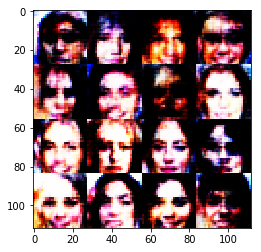

Batch No.: 6100 Discriminator Loss: 0.9172911643981934 Generative Loss: 1.6202037334442139
Batch No.: 6200 Discriminator Loss: 1.0960338115692139 Generative Loss: 0.882993757724762
Batch No.: 6300 Discriminator Loss: 2.3830995559692383 Generative Loss: 0.5425522327423096
Batch No.: 6400 Discriminator Loss: 1.4002666473388672 Generative Loss: 0.6267479062080383
Batch No.: 6500 Discriminator Loss: 1.3139704465866089 Generative Loss: 0.7592635154724121


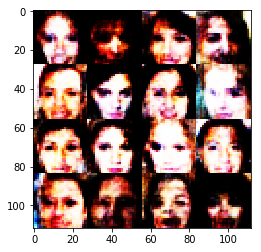

Batch No.: 6600 Discriminator Loss: 1.0378096103668213 Generative Loss: 0.9431939721107483
Batch No.: 6700 Discriminator Loss: 0.8227881789207458 Generative Loss: 1.040611743927002
Batch No.: 6800 Discriminator Loss: 1.1458724737167358 Generative Loss: 0.6265552043914795
Batch No.: 6900 Discriminator Loss: 2.4810380935668945 Generative Loss: 0.5585113763809204
Batch No.: 7000 Discriminator Loss: 1.180100679397583 Generative Loss: 1.0210230350494385


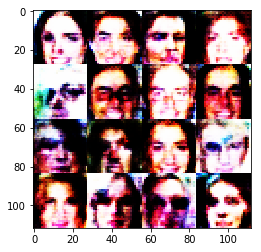

Batch No.: 7100 Discriminator Loss: 1.0904620885849 Generative Loss: 0.7313622236251831
Batch No.: 7200 Discriminator Loss: 1.596466302871704 Generative Loss: 0.42199212312698364
Batch No.: 7300 Discriminator Loss: 1.1621811389923096 Generative Loss: 0.968150794506073
Batch No.: 7400 Discriminator Loss: 0.7439178824424744 Generative Loss: 2.5233023166656494
Batch No.: 7500 Discriminator Loss: 1.45076322555542 Generative Loss: 0.7403721809387207


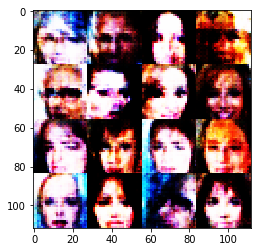

Batch No.: 7600 Discriminator Loss: 0.8023448586463928 Generative Loss: 1.0136511325836182
Batch No.: 7700 Discriminator Loss: 0.7831710577011108 Generative Loss: 1.4768970012664795
Batch No.: 7800 Discriminator Loss: 1.2127161026000977 Generative Loss: 0.783911406993866
Batch No.: 7900 Discriminator Loss: 0.9678686857223511 Generative Loss: 1.0910484790802002
Batch No.: 8000 Discriminator Loss: 0.7144243717193604 Generative Loss: 1.4946980476379395


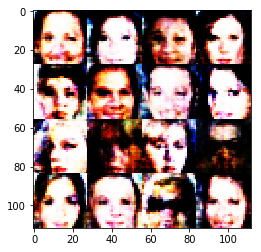

Batch No.: 8100 Discriminator Loss: 1.4509773254394531 Generative Loss: 0.8753625154495239
Batch No.: 8200 Discriminator Loss: 1.1179978847503662 Generative Loss: 0.8628875613212585
Batch No.: 8300 Discriminator Loss: 0.9199072122573853 Generative Loss: 0.8487166166305542
Batch No.: 8400 Discriminator Loss: 0.9785759449005127 Generative Loss: 1.0224237442016602
Batch No.: 8500 Discriminator Loss: 0.992323637008667 Generative Loss: 0.8733854293823242


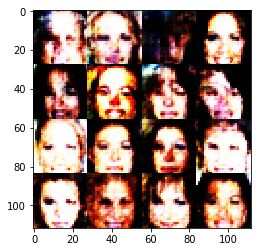

Batch No.: 8600 Discriminator Loss: 0.8525689840316772 Generative Loss: 1.251230239868164
Batch No.: 8700 Discriminator Loss: 1.1413679122924805 Generative Loss: 1.0197184085845947
Batch No.: 8800 Discriminator Loss: 1.2260582447052002 Generative Loss: 0.8301489353179932
Batch No.: 8900 Discriminator Loss: 1.705003261566162 Generative Loss: 0.5911452770233154
Batch No.: 9000 Discriminator Loss: 1.0372591018676758 Generative Loss: 1.6144018173217773


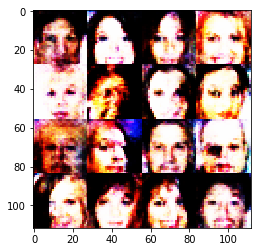

Batch No.: 9100 Discriminator Loss: 0.8707901239395142 Generative Loss: 0.7537236213684082
Batch No.: 9200 Discriminator Loss: 0.7907001376152039 Generative Loss: 1.4580765962600708
Batch No.: 9300 Discriminator Loss: 2.9493556022644043 Generative Loss: 0.46431708335876465
Batch No.: 9400 Discriminator Loss: 1.1196657419204712 Generative Loss: 1.8740642070770264
Batch No.: 9500 Discriminator Loss: 0.8385875821113586 Generative Loss: 1.4698996543884277


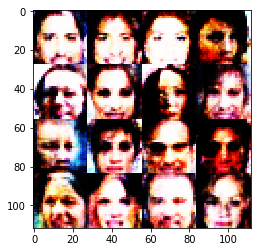

Batch No.: 9600 Discriminator Loss: 1.4702143669128418 Generative Loss: 0.887352705001831
Batch No.: 9700 Discriminator Loss: 1.3582688570022583 Generative Loss: 0.7982721924781799
Batch No.: 9800 Discriminator Loss: 1.5139762163162231 Generative Loss: 0.6635487079620361
Batch No.: 9900 Discriminator Loss: 0.6128500699996948 Generative Loss: 1.2748987674713135
Batch No.: 10000 Discriminator Loss: 1.3568423986434937 Generative Loss: 0.5491940975189209


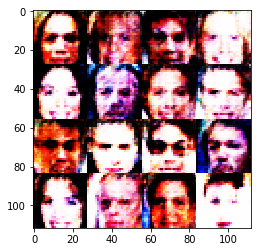

Batch No.: 10100 Discriminator Loss: 0.9279943108558655 Generative Loss: 0.9197337627410889
Batch No.: 10200 Discriminator Loss: 1.4380102157592773 Generative Loss: 0.700559139251709
Batch No.: 10300 Discriminator Loss: 0.9134085178375244 Generative Loss: 0.8558929562568665
Batch No.: 10400 Discriminator Loss: 1.5883724689483643 Generative Loss: 0.44909682869911194
Batch No.: 10500 Discriminator Loss: 0.7738920450210571 Generative Loss: 1.2016607522964478


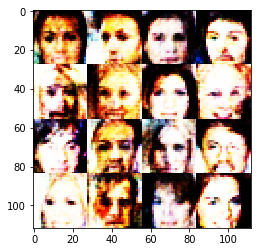

Batch No.: 10600 Discriminator Loss: 1.740508794784546 Generative Loss: 0.6486079096794128
Batch No.: 10700 Discriminator Loss: 1.2332816123962402 Generative Loss: 1.1406172513961792
Batch No.: 10800 Discriminator Loss: 0.8069457411766052 Generative Loss: 0.950743556022644
Batch No.: 10900 Discriminator Loss: 0.9444295763969421 Generative Loss: 0.9832092523574829
Batch No.: 11000 Discriminator Loss: 2.9753921031951904 Generative Loss: 0.6412340998649597


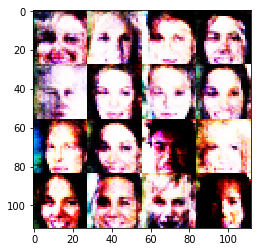

Batch No.: 11100 Discriminator Loss: 1.1289435625076294 Generative Loss: 0.8126940727233887
Batch No.: 11200 Discriminator Loss: 1.3563508987426758 Generative Loss: 0.6278918981552124
Batch No.: 11300 Discriminator Loss: 1.4713218212127686 Generative Loss: 0.6903027296066284
Batch No.: 11400 Discriminator Loss: 1.8098291158676147 Generative Loss: 0.6198660731315613
Batch No.: 11500 Discriminator Loss: 0.9238590002059937 Generative Loss: 0.9272745847702026


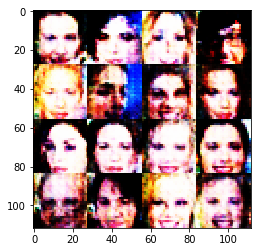

Batch No.: 11600 Discriminator Loss: 2.223965644836426 Generative Loss: 0.5854665040969849
Batch No.: 11700 Discriminator Loss: 1.2963943481445312 Generative Loss: 0.7155909538269043
Batch No.: 11800 Discriminator Loss: 0.9119489789009094 Generative Loss: 1.26346755027771
Batch No.: 11900 Discriminator Loss: 1.5145580768585205 Generative Loss: 0.6637471914291382
Batch No.: 12000 Discriminator Loss: 1.0682456493377686 Generative Loss: 1.1155214309692383


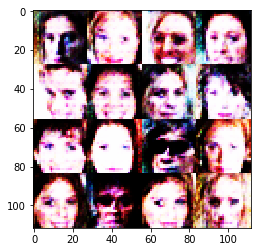

Batch No.: 12100 Discriminator Loss: 0.9485214948654175 Generative Loss: 0.9021581411361694
Batch No.: 12200 Discriminator Loss: 1.434173345565796 Generative Loss: 0.7119204998016357
Batch No.: 12300 Discriminator Loss: 0.8699402809143066 Generative Loss: 1.1633427143096924
Batch No.: 12400 Discriminator Loss: 1.3217918872833252 Generative Loss: 0.6391743421554565
Batch No.: 12500 Discriminator Loss: 1.9064652919769287 Generative Loss: 0.57574462890625


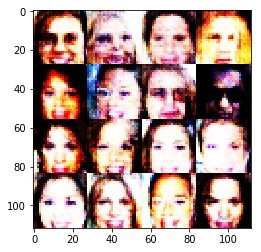

Batch No.: 12600 Discriminator Loss: 1.8378949165344238 Generative Loss: 0.5771340131759644
Epoch 1/1 Discriminator Loss: 1.8378949165344238 Generative Loss: 0.5771340131759644


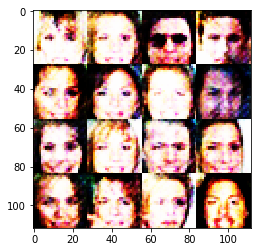

Model saved in path: /tmp/model.ckpt


In [41]:
batch_size = 16
z_dim = 100
learning_rate = 0.0008
beta1 = 0.33


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.